In [2]:
import os
import pandas as pd
import optuna
import numpy as np
from qiskit.circuit import QuantumCircuit

import qtpu

from benchmark._plot_util import *

from benchmark.ansatz import generate_ansatz, qaoa2
from benchmark.exec_ckt import cut_ckt
from qtpu.compiler.compiler import  compile_reach_size
from benchmark.util import get_info, append_to_csv
from qtpu.circuit import cuts_to_moves
from circuit_knitting.cutting.qpd import TwoQubitQPDGate

In [2]:
QPU_SIZE = 15


benches = {
    # "vqe": [generate_ansatz("linear", n, 2) for n in range(100, 101, 20)],
    "qml": [(generate_ansatz("zz", n, 3)) for n in range(20, 201, 40)],
    "vqe": [(generate_ansatz("linear", n, 3)) for n in range(20, 201, 40)],
    "qaoa2": [(qaoa2(n, 10, 3)) for n in range(2, 21, 4)],
}

In [ ]:
def overhead(circuit):
    circuit = cuts_to_moves(circuit)
    return sum(
        [
            np.log10(instr.operation.basis.overhead)
            for instr in circuit
            if isinstance(instr.operation, TwoQubitQPDGate)
        ]
    )


for name, bench_list in benches.items():
    for bench in bench_list:
        cut_circ = compile_reach_size(bench, QPU_SIZE, show_progress_bar=True)
        qtpu_res = {"qtpu_overhead": overhead(cut_circ)}

        cut_circ = cut_ckt(cut_circ, QPU_SIZE)
        ckt_res = {"ckt_overhead": overhead(cut_circ)}
        append_to_csv("compiler.csv", {"name": name, **qtpu_res, **ckt_res})

In [3]:
def plot_bar(df, ax, x, y, yerr=None):
    df.plot.bar(
        x=x, y=y, rot=0, width=0.8, edgecolor="black", linewidth=2, ax=ax, legend=False, yerr=yerr
    )

    hatches = ["**", "//", "oo", "xx", "oo", "OO"]

    color_to_hatch = {}

    i = 0
    for patch in ax.patches:
        if patch.get_facecolor() not in color_to_hatch:
            color_to_hatch[patch.get_facecolor()] = hatches[i % len(hatches)]
            i += 1

    for patch in ax.patches:
        patch.set_hatch(color_to_hatch[patch.get_facecolor()])

/tmp/ipykernel_753080/1888539606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vqe["num_qubits"] = range(20, 201, 40)
/tmp/ipykernel_753080/1888539606.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qml["num_qubits"] = range(20, 201, 40)


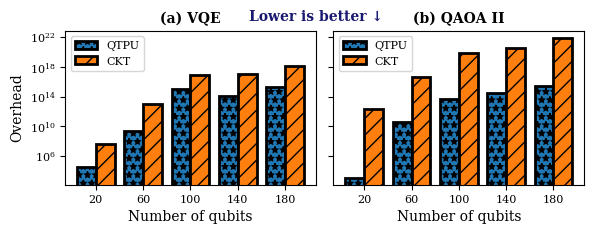

In [11]:
df = pd.read_csv("compiler.csv")

df_vqe = df[df["name"] == "vqe"]
df_vqe["num_qubits"] = range(20, 201, 40)
df_vqe = df_vqe.groupby(["name", "num_qubits"]).mean().reset_index().copy()

df_qml = df[df["name"] == "qaoa2"]
df_qml["num_qubits"] = range(20, 201, 40)
df_qml = df_qml.groupby(["name", "num_qubits"]).mean().reset_index().copy()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6.7, 2), sharey=True)
fig.subplots_adjust(wspace=0.07)

df_vqe["qtpu_overhead"] **= 10
df_qml["qtpu_overhead"] **= 10
df_vqe["ckt_overhead"] **= 10
df_qml["ckt_overhead"] **= 10

plot_bar(df_vqe, ax0, "num_qubits", None)
plot_bar(df_qml, ax1, "num_qubits", None)

ax0.set_ylabel("Overhead")
ax0.set_xlabel("Number of qubits")
ax1.set_xlabel("Number of qubits")

ax0.set_title("(a) VQE", fontweight="bold")
ax1.set_title("(b) QAOA II", fontweight="bold")
ax0.legend(["QTPU", "CKT"])
ax1.legend(["QTPU", "CKT"])

fig.text(0.5, .95, "Lower is better ↓", ha='center', va='center', fontweight="bold", color="midnightblue")
ax0.set_yscale("log")

In [12]:
fig.savefig("compiler.pdf", bbox_inches="tight")